In [111]:
import pandas as pd
from datetime import datetime
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
# Right after importing seaborn (could also use 'whitegrid')
sns.set_theme(style='darkgrid', context='talk')

import warnings
warnings.filterwarnings('ignore')

from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
from numpy import sqrt


In [2]:
url = 'https://raw.githubusercontent.com/sujansth/Ecommerce-demand-prediction/master/data/Nike_sales.csv'

df = pd.read_csv(url)

In [3]:
df

,date,total_revenue
0,2019-06-01,2523.329360
1,2019-06-02,65.848326
2,2019-06-03,638.971981
3,2019-06-04,45796.446679
4,2019-06-05,42551.689671
...,...,...
953,2022-01-10,58974.390087
954,2022-01-11,61727.415091
955,2022-01-12,55408.940166
956,2022-01-13,51633.944288


In [98]:
df = df.rename(columns={'date':'ds', 'total_revenue':'y'})

In [99]:
df['ds'] = pd.to_datetime(df['ds'])

In [6]:
df.shape

(958, 2)

In [7]:
df

,ds,y
0,2019-06-01,2523.329360
1,2019-06-02,65.848326
2,2019-06-03,638.971981
3,2019-06-04,45796.446679
4,2019-06-05,42551.689671
...,...,...
953,2022-01-10,58974.390087
954,2022-01-11,61727.415091
955,2022-01-12,55408.940166
956,2022-01-13,51633.944288


In [100]:
train_df = df[:866]
test_df = df[866:]

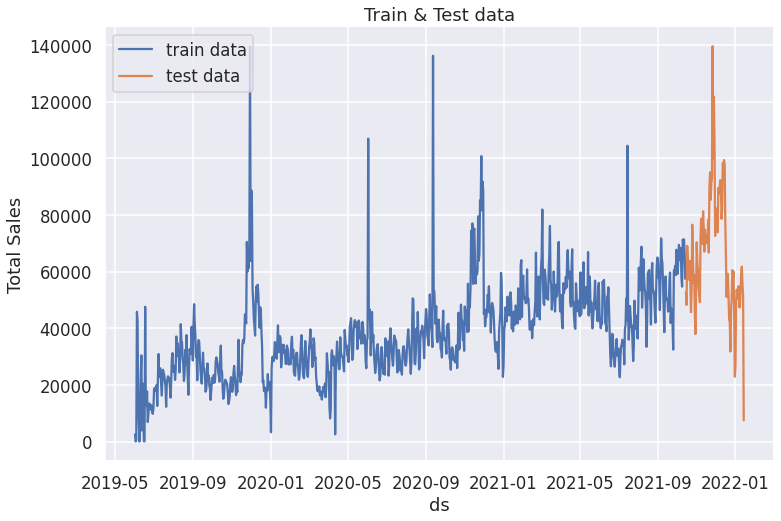

In [101]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x='ds', y='y', data=train_df, label='train data')
sns.lineplot(x='ds', y='y', data=test_df, label='test data')

ax.legend(loc='upper left')
ax.set(title="Train & Test data", ylabel='Total Sales')
plt.show()

In [102]:
# Trainin the model

model = Prophet(seasonality_mode='multiplicative')
model.add_seasonality(name='monthly', period=30, fourier_order=10)
model.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [103]:
future = model.make_future_dataframe(periods=90, freq='d', include_history=False)
forecast = model.predict(future)
forecast[['ds','yhat']]

,ds,yhat
0,2021-10-15,45784.354872
1,2021-10-16,42761.786434
2,2021-10-17,53487.496462
3,2021-10-18,56889.400573
4,2021-10-19,53005.070105
...,...,...
85,2022-01-08,54096.934741
86,2022-01-09,66802.832703
87,2022-01-10,71926.511232
88,2022-01-11,69091.532572


In [39]:
!pip install prophet


     |████████████████████████████████| 65 kB 2.0 MB/s 
     |████████████████████████████████| 49 kB 4.3 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640250 sha256=3f9a157e5ac2f1bb731399a70154495c87dea09c57b0819958d415d242799687
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


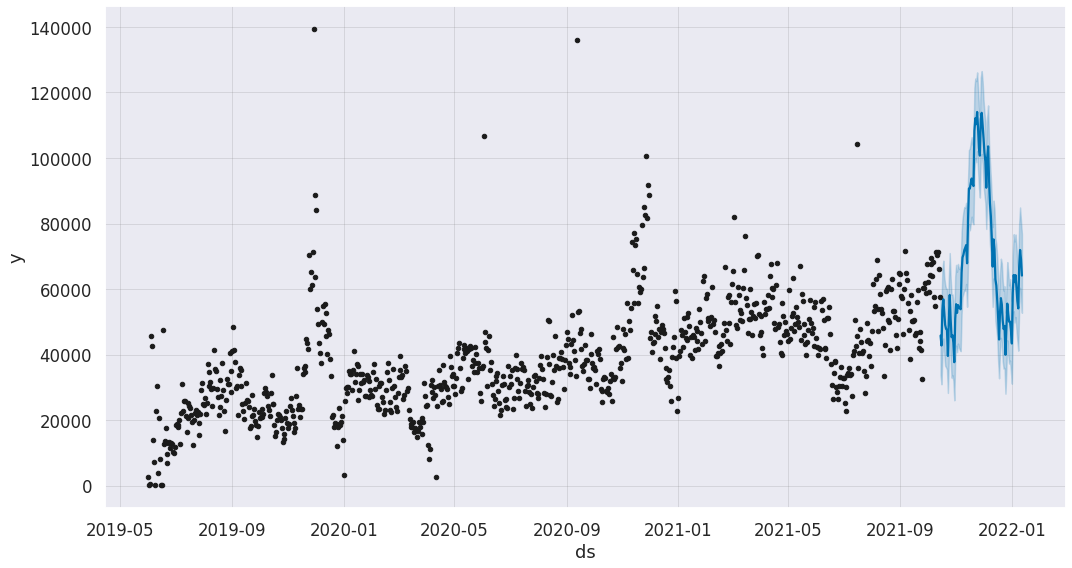

In [104]:
# ploting the forecast

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=model.plot(forecast, ax=ax)

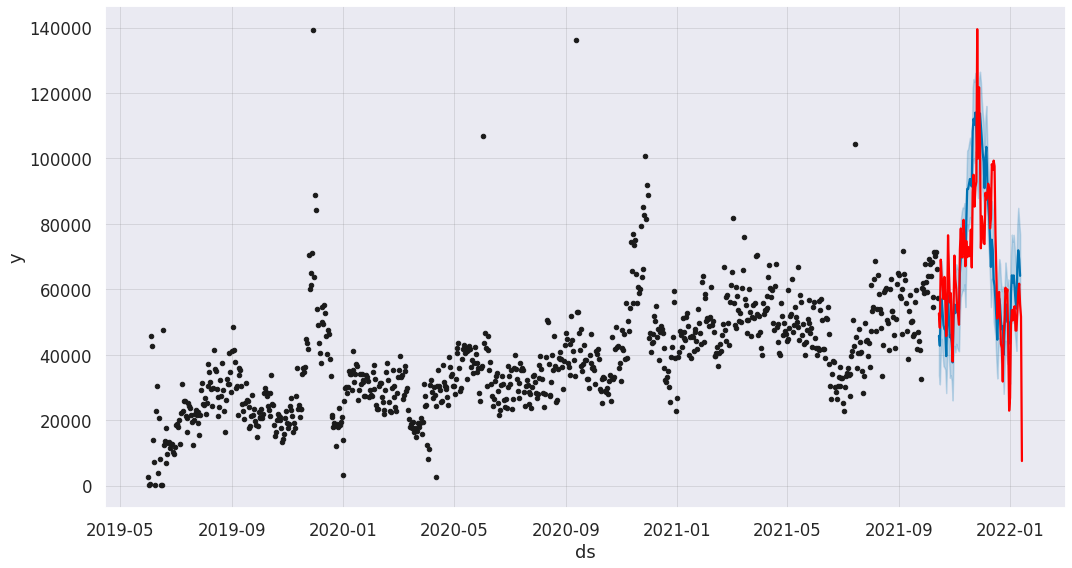

In [105]:
# comparing Forecast vs Actual

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


fig=model.plot(forecast, ax=ax)
ax.plot(test_df.ds, test_df.y, color='red')


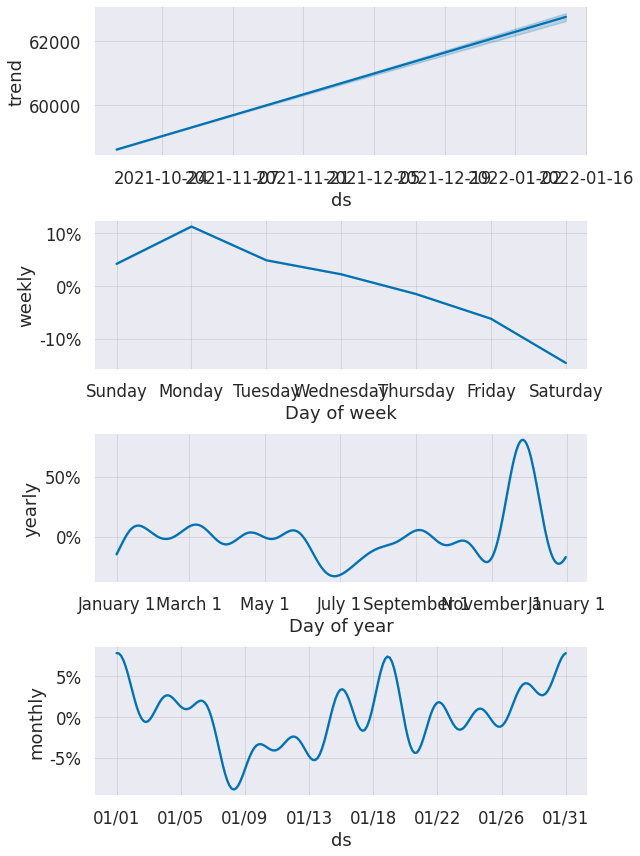

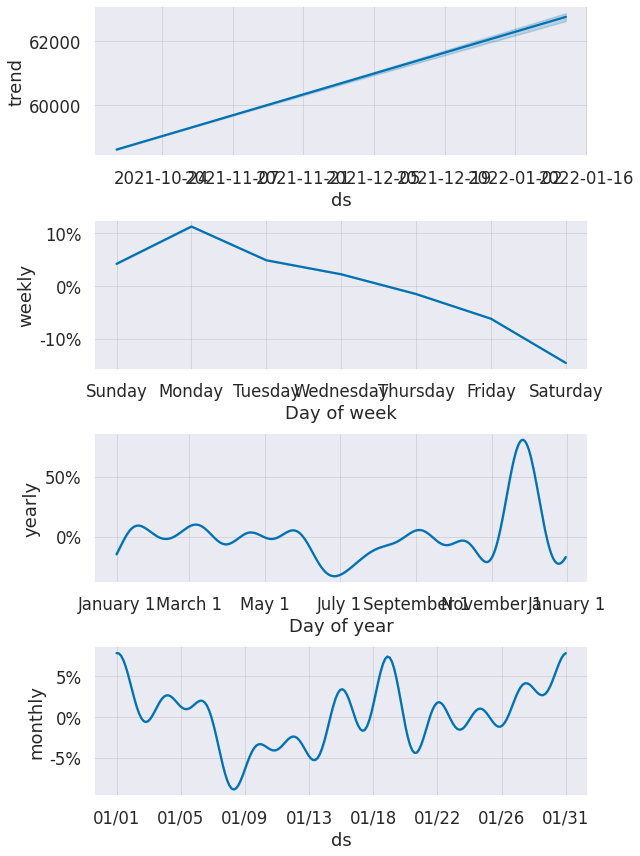

In [83]:
# plotting model components

model.plot_components(forecast)

In [106]:
from sklearn.metrics import mean_squared_error
from math import sqrt

error = sqrt(mean_squared_error(test_df.y[:-2], forecast.yhat))
print('Test RMSE: %.3f' % error)

Test RMSE: 14779.406


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


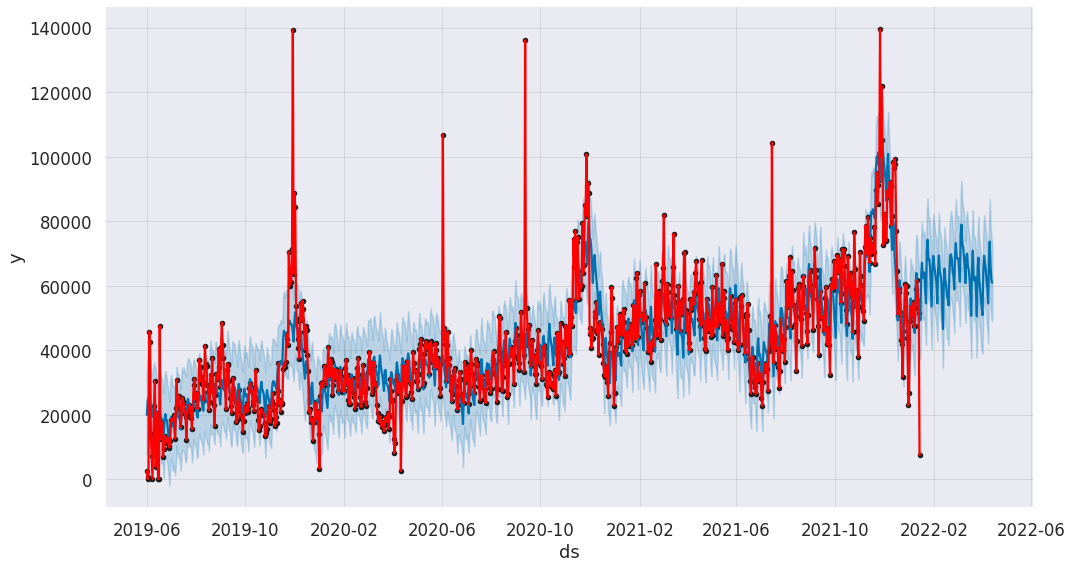

In [90]:
# Now fitting the whole data set

model = Prophet(seasonality_mode='multiplicative')
model.add_seasonality(name='monthly', period=30, fourier_order=10)
model.fit(df)


future = model.make_future_dataframe(periods=90, freq='d', include_history=True)
forecast = model.predict(future)
forecast[['ds','yhat']]



# comparing Forecast to Actual

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=model.plot(forecast, ax=ax)
ax.plot(df.ds, df.y, color='red')


In [107]:
three_months_prediction = pd.DataFrame(forecast[['ds','yhat']][-90:])
three_months_prediction.head()

,ds,yhat
0,2021-10-15,45784.354872
1,2021-10-16,42761.786434
2,2021-10-17,53487.496462
3,2021-10-18,56889.400573
4,2021-10-19,53005.070105


In [113]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Cross Validation
df_cv=cross_validation(model, horizon='90 days', initial='90', period='90 days')

mape=mean_absolute_percentage_error(df_cv.y, df_cv.yhat)
print('MAPE: ', mape)

INFO:fbprophet:Making 9 forecasts with cutoffs between 2019-07-27 00:00:00 and 2021-07-16 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

MAPE:  70.75898743463644


In [114]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-07-28,13613.326895,11405.786311,15630.755115,21733.776093,2019-07-27
1,2019-07-29,14043.560615,11573.219258,16370.030494,29238.709588,2019-07-27
2,2019-07-30,22227.120060,18626.224228,25855.753896,31231.340137,2019-07-27
3,2019-07-31,37829.152334,28489.610648,45395.627054,24850.840163,2019-07-27
4,2019-08-01,34935.339739,23490.709233,45115.234665,24659.228089,2019-07-27


In [115]:
### Performance Metrics
from fbprophet.diagnostics import performance_metrics
df_perf = performance_metrics(df_cv)
df_perf

,horizon,mse,rmse,mae,mape,mdape,coverage
0,9 days,1.430932e+08,11962.155222,10067.048667,0.318046,0.298218,0.506173
1,10 days,1.673037e+08,12934.594876,11129.913485,0.346265,0.327428,0.444444
2,11 days,1.983093e+08,14082.231953,12510.327489,0.379955,0.363943,0.358025
3,12 days,2.320015e+08,15231.594758,13779.538295,0.415961,0.416935,0.296296
4,13 days,2.610002e+08,16155.499914,14603.095375,0.437350,0.422504,0.271605
...,...,...,...,...,...,...,...
77,86 days,1.032546e+09,32133.259117,27212.641758,1.063574,0.748775,0.283951
78,87 days,9.911131e+08,31481.948840,26566.618195,1.048245,0.595845,0.283951
79,88 days,9.501098e+08,30823.851788,26006.011355,0.855087,0.564458,0.283951
80,89 days,9.163041e+08,30270.516089,25411.690959,0.823759,0.539210,0.296296


Text(0.5, 1.0, ' Forecast Vs Actual')

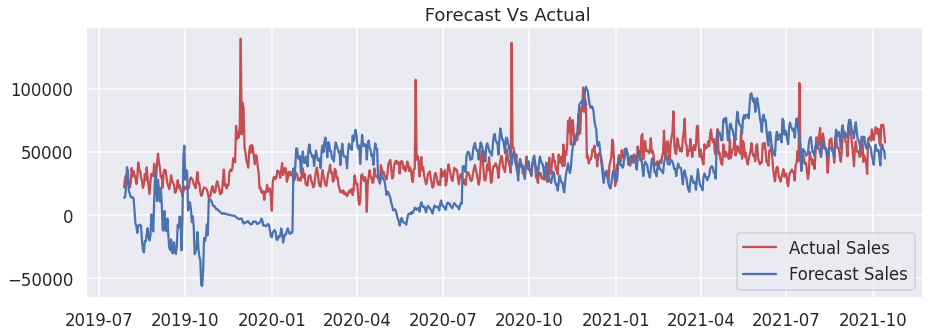

In [116]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(df_cv['ds'], df_cv['y'], color='r', label='Actual Sales')
ax.plot(df_cv['ds'], df_cv['yhat'], color='b', label='Forecast Sales')
plt.legend()



plt.title(' Forecast Vs Actual')

In [118]:
# Hyperparameter tuning

from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [119]:
import itertools
param_grid = {'seasonality_mode':('multiplicative','additive'),  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
             'n_changepoints' : [3, 6, 9, 12, 15, 18, 21, 24, 25, 30]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    cutoffs=pd.to_datetime(['2020-03-03','2020-04-28'])
    m = Prophet(**params).fit(train_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

#https://facebook.github.io/prophet/docs/diagnostics.html

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7e762b7450>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7e76096e90>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7e76408a50>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7e762349d0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in par

    seasonality_mode  changepoint_prior_scale  seasonality_prior_scale  \
0     multiplicative                    0.001                     0.01   
1     multiplicative                    0.001                     0.01   
2     multiplicative                    0.001                     0.01   
3     multiplicative                    0.001                     0.01   
4     multiplicative                    0.001                     0.01   
..               ...                      ...                      ...   
315         additive                    0.500                    10.00   
316         additive                    0.500                    10.00   
317         additive                    0.500                    10.00   
318         additive                    0.500                    10.00   
319         additive                    0.500                    10.00   

     n_changepoints           rmse  
0                 3   18035.450333  
1                 6   18587.839743  


In [121]:
tuning_results.sort_values('rmse')

,seasonality_mode,changepoint_prior_scale,seasonality_prior_scale,n_changepoints,rmse
131,multiplicative,0.5,0.1,6,9341.551322
139,multiplicative,0.5,0.1,30,9406.914619
138,multiplicative,0.5,0.1,25,9846.434365
135,multiplicative,0.5,0.1,18,9863.808457
137,multiplicative,0.5,0.1,24,9936.108865
...,...,...,...,...,...
270,additive,0.1,10.0,3,143784.026845
271,additive,0.1,10.0,6,143970.002081
311,additive,0.5,10.0,6,147585.108097
157,multiplicative,0.5,10.0,24,201741.748607


In [122]:
final_model = Prophet(growth='linear', seasonality_mode='multiplicative', changepoint_prior_scale=0.5, seasonality_prior_scale=0.1, n_changepoints=6)
final_model.add_seasonality(name='monthly', period=30, fourier_order=10)
final_model.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [127]:
future = final_model.make_future_dataframe(periods=90, freq='d', include_history=False)
final_forecast = final_model.predict(future)
final_forecast[['ds','yhat']]

,ds,yhat
0,2021-10-15,46434.145596
1,2021-10-16,43661.787418
2,2021-10-17,54394.818495
3,2021-10-18,57932.564566
4,2021-10-19,54301.333614
...,...,...
85,2022-01-08,64932.800160
86,2022-01-09,77594.659665
87,2022-01-10,83047.998102
88,2022-01-11,80563.446117


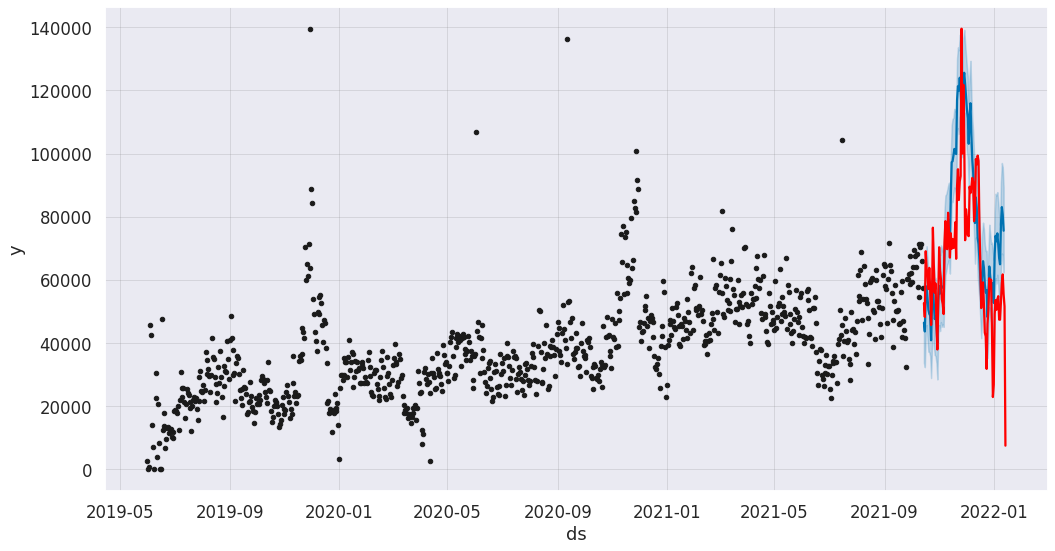

In [136]:
# comparing Forecast (based on 30 days after train data) vs test_data

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


fig = final_model.plot(final_forecast, ax=ax)
ax.plot(test_df.ds, test_df.y, color='red')

Text(0.5, 1.0, 'Forecast VS Actual Daily Sales')

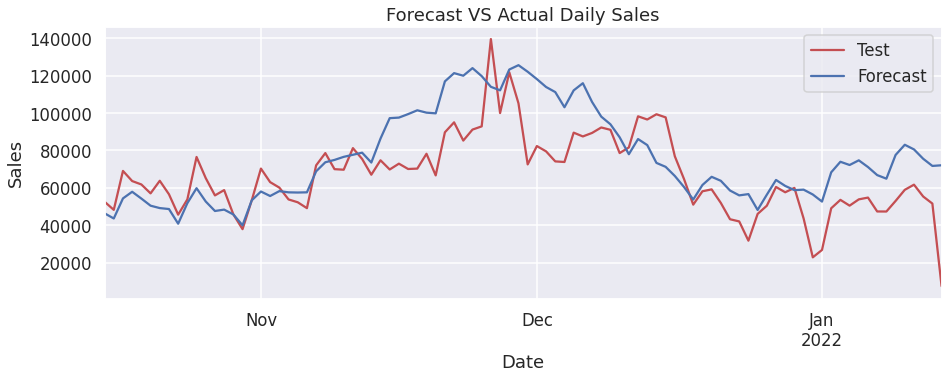

In [135]:
# Plot the forecast with the actuals
x_test_forecast=final_model.predict(test_df)

f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(5)
f.set_figwidth(15)
test_df.plot(x='ds', y='y', color='r', label='Test', ax=ax)
x_test_forecast.plot(x='ds', y='yhat', label='Forecast', ax=ax)
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Forecast VS Actual Daily Sales')

In [137]:
mape=mean_absolute_percentage_error(test_df.y, x_test_forecast.yhat)
print('MAPE: ', mape)

MAPE:  33.13874109106012
